## Predicting the temperature 24 hours in the future
given a timeseries of hourly measurement of quantities. We will show that densely-connected networks and convolutional networks aren't well-equiped to deal with it, and demonstrate a new kind of machine learning technique that really shines on this type of problem: recurrent neural networks (RNNs).

Inspecting the data of the Jena weather dataset.

In [1]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()
    
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


This outputs a count of 420451 lines of data. Each line is a timestep: a record of a data and 14 weather-related values.

Parsing the data

In [2]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    # print(values)
    temperature[i] = values[1]
    raw_data[i,:] = values[:]

Plotting the temperature timeseries-the data spans 8 years.

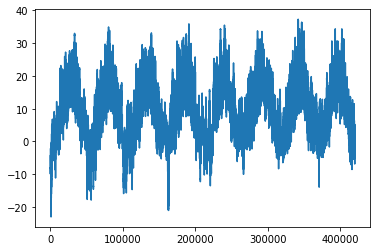

In [3]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

Plotting the first 10 days of the temperature timeseries.

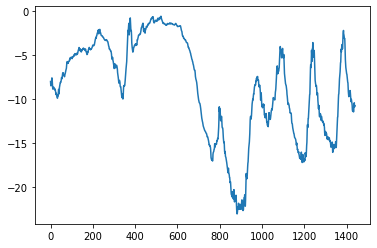

In [4]:
plt.plot(range(1440), temperature[:1440])

Always look for periodicity in our data.

In our experiments, we'll use the first 50% of the data for training, the following 25% for validation, and the last 25% for testing. When working with timeseries data, it's important to use validation and test data that is more recent than the training data, because we're trying to predict the future given the past, and our validation/test splits should reflect.

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### 10.2.1 Preparing the data
Each data is on a different scale. We'll normalize each timeseries independently so that they all take small values on a similar scale. We're going to use the first 210225 timesteps as training data, so we'll compute the mean and sd only on this fraction of the data.

Normalizing data

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Instantiating Datasets for training, validation, and testing.

In [7]:
import numpy as np
from tensorflow import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Each dataset yields a tuple (samples, targets), where $samples$ is a batch of 256 samples, each containing 120 consecutive hours of input data, and $targest$ is the corresponding array of 256 targets temperatures. Note that the samples are randomly shuffled, so two consecutive sequences in a batch (like $samples[0]$ and $samples[1]$) aren't necessarily temporally close.

In [8]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


Computing the common-sense baseline MAE:

In [9]:
def evaluate_naive_method(dataset):
    total_abs_err = 0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1]*std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Let's try a basic machine learning model.

Training and evaluating a densely connected model.

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                            save_best_only=True)]
model.compile(optimizer="rmsprop",
             loss="mse",
             metrics=["mae"])
history = model.fit(train_dataset,
                   epochs=10,
                   validation_data = val_dataset,
                   callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 45s 51ms/step - loss: 12.8909 - mae: 2.7735 - val_loss: 16.0606 - val_mae: 3.2017
Epoch 2/10
819/819 [==============================] - 44s 53ms/step - loss: 8.9029 - mae: 2.3443 - val_loss: 11.5346 - val_mae: 2.6605
Epoch 3/10
819/819 [==============================] - 45s 54ms/step - loss: 8.1343 - mae: 2.2436 - val_loss: 10.3196 - val_mae: 2.5328
Epoch 4/10
819/819 [==============================] - 42s 51ms/step - loss: 7.6504 - mae: 2.1803 - val_loss: 10.8671 - val_mae: 2.5949
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 7.3213 - mae: 2.1341 - val_loss: 11.1414 - val_mae: 2.6319
Epoch 6/10
819/819 [==============================] - 43s 52ms/step - loss: 7.1055 - mae: 2.1030 - val_loss: 10.7877 - val_mae: 2.5866
Epoch 7/10
819/819 [==============================] - 43s 52ms/step - loss: 6.9297 - mae: 2.0776 - val_loss: 12.5320 - val_mae: 2.8011
Epoch 8/10
819/819 [==============================] - 

Plotting results.

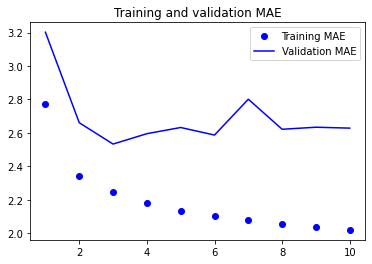

In [11]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Let's try a 1D convolutaional model.

In [12]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                             save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 53s 59ms/step - loss: 23.6349 - mae: 3.7931 - val_loss: 14.9814 - val_mae: 3.0526
Epoch 2/10
819/819 [==============================] - 50s 61ms/step - loss: 15.5788 - mae: 3.1359 - val_loss: 14.9176 - val_mae: 3.0844
Epoch 3/10
819/819 [==============================] - 47s 58ms/step - loss: 14.0254 - mae: 2.9703 - val_loss: 15.2160 - val_mae: 3.1248
Epoch 4/10
819/819 [==============================] - 48s 58ms/step - loss: 13.1701 - mae: 2.8783 - val_loss: 16.3162 - val_mae: 3.1802
Epoch 5/10
819/819 [==============================] - 48s 58ms/step - loss: 12.5076 - mae: 2.8051 - val_loss: 18.5572 - val_mae: 3.3780
Epoch 6/10
819/819 [==============================] - 48s 58ms/step - loss: 12.0076 - mae: 2.7499 - val_loss: 15.6588 - val_mae: 3.1118
Epoch 7/10
819/819 [==============================] - 48s 58ms/step - loss: 11.5765 - mae: 2.7009 - val_loss: 17.1519 - val_mae: 3.2466
Epoch 8/10
819/819 [============================

Plotting the result.

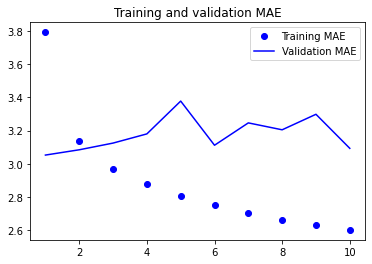

In [13]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

This model performs even worse than the densely-connected one, only achieving a validation MAE of about 2.9 degrees. What went wrong? two things:
1. Weather data doesn't quite respect the translation invariance assumption. While the data does feature daily cycles, data from a morning follows different properties than data from an evening or from the middle of the night. Weather data is only translation-invariant for a very specific timescale.
2. Second, order in our data matters-a lot. The recent past is far more informative to predict the next day’s temperature than data from five days ago. A 1D convnet is not able to leverage this fact. In particular, our max pooling and global average pooling layers are largely destroying order information.

### 10.2.5 A first recurrent baseline
Let's instead look at the data as what it is: a sequence, where causality and order matter. There's a family of nn architectures that were designed specifically for this use case: RNNs. Among them, the Long Short Term Memory(LSTM) layer in particular has long been very popular.

Let's start giving the LSTM layer a try. A simple LSTM-based model.

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                             save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print("Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 61s 72ms/step - loss: 44.4192 - mae: 4.8677 - val_loss: 13.3445 - val_mae: 2.7855
Epoch 2/10
819/819 [==============================] - 59s 71ms/step - loss: 11.1196 - mae: 2.5974 - val_loss: 9.7787 - val_mae: 2.4435
Epoch 3/10
819/819 [==============================] - 59s 72ms/step - loss: 9.7528 - mae: 2.4451 - val_loss: 9.6262 - val_mae: 2.4205
Epoch 4/10
819/819 [==============================] - 59s 72ms/step - loss: 9.3324 - mae: 2.3908 - val_loss: 9.8068 - val_mae: 2.4174
Epoch 5/10
819/819 [==============================] - 60s 73ms/step - loss: 8.9674 - mae: 2.3387 - val_loss: 10.0900 - val_mae: 2.4402
Epoch 6/10
819/819 [==============================] - 59s 72ms/step - loss: 8.7767 - mae: 2.3117 - val_loss: 9.9965 - val_mae: 2.4452
Epoch 7/10
819/819 [==============================] - 59s 72ms/step - loss: 8.6594 - mae: 2.2947 - val_loss: 9.9480 - val_mae: 2.4443
Epoch 8/10
819/819 [==============================] - 59s 

Plotting the result.

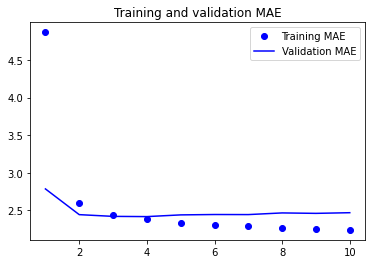

In [15]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()